In [1]:
import tensorflow.keras as keras
import tensorflow.keras.preprocessing.image as Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import os

In [2]:
import tensorflow as tf

tf.device('/device:GPU:0')

In [3]:
INIT_LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32
SPLIT = 0.1

In [4]:
imagePaths = list(paths.list_images('data/'))
train_dataset = [] # 이미지가 들어갈 list
labels = [] # 이미지에 해당하는 label(mask, no mask, eme-mask)이 들어갈 리스트

# 이미지 데이터를 읽어와 이름으로부터 label을 분리해내고, 이미지를 numpy 배열 형태로 바꿔놓습니다.
for i, imagePath in enumerate(imagePaths):
    label = imagePath.split(os.path.sep)[-2] # ibird/user/model/nomask/image_2342.jpg 와 같은 식의 경로에서 /로 나누고 뒤에서 두번쨰(즉, label)값을 얻어내겟다.
    image = Image.load_img(imagePath, target_size=(128, 128)) # 이미지를 불러온다. 단, 이미지 크기는 224 * 224로 설정하여
    image = Image.img_to_array(image) # 이미지 가져온 것을 array형태로 바꾸겠다.
    if not i % 1000:
        print(i, '/', len(imagePaths))

    train_dataset.append(image)
    labels.append(label)

train_dataset = np.array(train_dataset, dtype='float32')
#labels = np.array(labels)

0 / 8982
1000 / 8982
2000 / 8982
3000 / 8982
4000 / 8982
5000 / 8982
6000 / 8982
7000 / 8982
8000 / 8982


In [5]:
class_mapping = list(np.unique(labels))
#print(class_mapping)
for i in range(len(labels)):
  for j, cls in enumerate(class_mapping):
    if labels[i] == cls:
      mapping = [0, 0, 0]
      mapping[j] = 1
      labels[i] = mapping

In [6]:
labels = np.array(labels) #, dtype=int)

In [7]:
# 학습, 테스트 데이터셋으로 나눈다.
(train_dataset, test_dataset, train_target, test_target) = train_test_split(train_dataset, labels, test_size=SPLIT, stratify=labels, random_state=92)

In [8]:
# 이미지 데이터량을 보충을 위해 Image Augmentation을 설정해둡니다.
# 원하는 augmentation을 넣습니다. 어떤 것을 넣으면 성능이 올라가고 오히려 반대로 떨어지기도 합니다.
augmentation = Image.ImageDataGenerator(
	zoom_range=0.15,
	width_shift_range=0.3,
	height_shift_range=0.3,
	fill_mode="nearest")

In [9]:
# 전이학습

from tensorflow.keras.layers import Input

# mobilenetv2 pretrain된 버전을 가져옵니다.
# moblienet은 Depth wise Convolution(채널을 분리해내 따로 CNN을 계산을 하고 다시 합치는) 기법을 통해 연산량을 줄여 경량화한 모델
baseModel = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

In [10]:
# mobilenet에 classifier(분류기)를 만들어 이어붙입니다.
headModel = baseModel.output
headModel = keras.layers.AveragePooling2D(pool_size=(4, 4))(headModel) # 평균을 내는 pooling layer
headModel = keras.layers.Flatten(name='flatten')(headModel) # flatten함수를 사용하여 2차원 배열을 1차원배열로 만든다
headModel = keras.layers.Dense(128, activation='relu')(headModel) # DNN 층 activation은 relu를 사용하였다.
headModel = keras.layers.Dropout(0.5)(headModel) # dropout을 사용하여 과적합을 막는다.
headModel = keras.layers.Dense(3, activation='softmax')(headModel) # DNN 층 사용. 목표 클래스는 2개이므로 output이 2개로 나오도록 설정. 그리고 activation은 softmax

model = keras.models.Model(inputs=baseModel.input, outputs=headModel) # moblienet과 만든 classifier를 합쳐 새로운 모델로

# basemodel(mobilenet)만 freeze시키고, classifier만 학습되도록 설정해둡니다.
# basemodel을 freeze시키지 않고도 사용 가능합니다.
for layer in baseModel.layers:
  layer.trainable = False

In [11]:
# 체크 포인트를 설정하여 val_loss가 가장 개선되었을 때 해당 모델이 저장되도록 설정합니다.
checkpoint = keras.callbacks.ModelCheckpoint('checkpoint-best.h5',   # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

In [12]:
# 스케쥴러 설정
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else: # lr 10 이상부터 점점 감소
    return lr * tf.math.exp(-0.1)

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
callbacks = [checkpoint, scheduler_callback]

In [14]:
# 'Adam optimizer'를 가져옵니다. 그리고 'loss function'은 'binary_cross_entropy'로 설정합니다.
optimizer = keras.optimizers.Adam(learning_rate=INIT_LEARNING_RATE, decay=INIT_LEARNING_RATE / EPOCHS)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 위에 설정값들을 이용해서 모델을 학습시킵니다.
# validation(검증 즉 모의고사 같은 것) - 용도: 과적합 정도를 알아보기 위한 용도
# augmentation을 설정한 버전
"""
H = model.fit(augmentation.flow(train_dataset, train_target, batch_size=BATCH_SIZE),
              steps_per_epoch=len(train_dataset) // BATCH_SIZE,
              validation_data=(test_dataset, test_target),
              validation_steps=len(test_dataset) // BATCH_SIZE,
              callbacks=callbacks,
              epochs = EPOCHS)
"""
# augmentation을 제거한 버전
H = model.fit(x=train_dataset, y=train_target, batch_size=BATCH_SIZE,
              steps_per_epoch=len(train_dataset) // BATCH_SIZE,
              validation_data=(test_dataset, test_target),
              validation_steps=len(test_dataset) // BATCH_SIZE,
              callbacks=callbacks,
              epochs = EPOCHS)
              

Epoch 1/50
266/266 [==============================] - 19s 25ms/step - loss: 0.2918 - accuracy: 0.8292 - val_loss: 0.1765 - val_accuracy: 0.8973

Epoch 00001: val_loss improved from inf to 0.17651, saving model to checkpoint-best.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
266/266 [==============================] - 6s 21ms/step - loss: 0.1795 - accuracy: 0.8978 - val_loss: 0.1514 - val_accuracy: 0.9196

Epoch 00002: val_loss improved from 0.17651 to 0.15139, saving model to checkpoint-best.h5
Epoch 3/50
266/266 [==============================] - 6s 21ms/step - loss: 0.1579 - accuracy: 0.9138 - val_loss: 0.1550 - val_accuracy: 0.8884

Epoch 00003: val_loss did not improve from 0.15139
Epoch 4/50
266/266 [==============================] - 6s 22ms/step - loss: 0.1388 - accuracy: 0.9232 - val_loss: 0.1473 - val_accuracy: 0.9107

Epoch 00004: val_loss improved from 0.15139 to 0.14734, saving model to checkpoint-best.h5
Epoch 5/50
266/266 [==============================] - 6s 22ms/step - loss: 0.1286 - accuracy: 0.9288 - val_loss: 0.1454 - val_accuracy: 0.9062

Epoch 00005: val_loss improved from 0.14734 to 0.14540, saving model to checkpoint-best.h5
Epoch 6/50
266/266 [==============================] - 6s 22ms/step - loss: 0.1189 - accuracy: 0.9341

In [18]:
# 테스트셋을 이용해 예측값(label별 확률)을 얻어냅니다.
# predIdx = model.predict(test_dataset, batch_size=BATCH_SIZE)

# 확률이 가장 높은 label index를 얻어냅니다
# predIdx = np.argmax(predIdx, axis=1)

# 모델 저장
model.save('mask_detector', save_format='h5') # mask_detector123.h5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


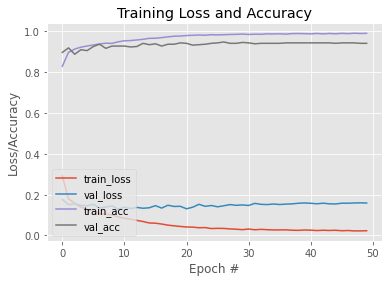

In [16]:
# 모델 학습 loss, accuracy 그래프 출력
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")